# Installation

## Installing sqlalchemy-iris
The following code install the sqlalchemy-iris library - an InterSystems IRIS dialect for SQLAlchemy.

In [1]:
!pip install sqlalchemy-iris

## Installing Additional Libraries
Apart from the SDK, we'll need several other Python libraries for data processing and visualization:

In [2]:
!pip install pandas numpy matplotlib scikit-learn==1.3.1

# Setting up InterSystems Cloud SQL with IntegratedML
Before we can connect to InterSystems Cloud SQL, we need to set it up. Instructions can be found in the provided notebook:

Refer to [this notebook](../cloud-sql-instruct/InterSystems%20IntegratedML%20Cloud%20SQL.ipynb) to see how to get access to IntegratedML.

# Connecting to the IRIS Database
Once set up, we can establish a connection to the IRIS database using the following:

In [3]:
# Required libraries
from sqlalchemy import create_engine, text, DateTime
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [4]:
# InterSystems IRIS Cloud SQL connection parameters
# You can define these parameters using the following environment 
# variables or you can hardcode them, just be aware to not publish 
# your credntials in public repos like github for instance
args = {
    'hostname': os.getenv("ISC_CLOUD_SQL_HOSTNAME"), 
    'port': os.getenv("ISC_CLOUD_SQL_PORT"),
    'namespace': os.getenv("ISC_CLOUD_SQL_NAMESPACE"), 
    'username': os.getenv("ISC_CLOUD_SQL_USER"),  
    'password': os.getenv("ISC_CLOUD_SQL_PWD") 
}

In [5]:
# Create a sqlalchemy connection to IRIS
engine = create_engine(f"iris://{args['username']}:{args['password']}@{args['hostname']}:{args['port']}/{args['namespace']}")
conn = engine.connect()

C:\Users\jrper\dev\venv\Lib\site-packages\sqlalchemy_iris\base.py:888: SAWarning: There are no access to %Dictionary, may be required for some advanced features, such as Calculated fields, and include columns in indexes                
  util.warn(


# Data ingestion
This part deals with data preparation, specifically reading and ingesting data into the IRIS database:

In [6]:
# Set pandas to display all columns; default is 20
pd.options.display.max_columns = None

In [7]:
# Load the trainning dataset from the CSV file, enforcing pandas to interpret columns tpep_pickup_datetime and tpep_dropoff_datetime as timestramp
# Note: this dataset was downloaded from https://www.kaggle.com/datasets/joniarroba/noshowappointments
train_df = pd.read_csv("./patient_encounters_train.csv")
train_df

,AdmitReason,MxWillReAdmit,DxDischargeLocation,DxGenderViaPatient,DxAgeGroup,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,DxEncounterType,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
0,SNOMED Code,0,N,M,51-60,53,0,0,2010,2010,11,1,7,0,1,0,0,0,0,1,1,0,10,7,7,I,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SNOMED Code,0,H,F,51-60,51,0,0,2012,2012,11,3,12,1,0,0,0,0,0,1,1,0,10,2,12,I,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,SNOMED Code,0,H,F,71+,73,0,0,2019,2019,2,4,10,0,1,0,0,0,0,1,2,0,1,3,10,I,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SNOMED Code,1,H,M,41-50,48,0,0,1978,1978,1,6,9,0,1,0,0,0,0,0,1,0,31,5,8,I,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,SNOMED Code,0,H,M,41-50,48,0,0,1978,1978,5,3,9,0,1,1,1,1,1,1,2,0,4,2,9,I,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Encounter Inpatient,0,H,M,31-40,33,0,1,2012,2012,21,5,6,1,0,0,2,1,4,0,0,0,20,4,6,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,Encounter Inpatient,0,N,M,31-40,33,0,1,2012,2012,4,7,8,1,0,0,3,1,4,0,0,0,3,6,8,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,Encounter Inpatient,0,H,M,31-40,33,0,1,2012,2012,24,2,12,1,0,0,1,0,4,0,0,0,23,1,12,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,Encounter Inpatient,0,H,M,31-40,33,0,1,2013,2013,13,4,2,1,0,0,1,1,5,0,0,0,12,3,2,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Display basic statistics of the training dataset
train_df.describe()

,MxWillReAdmit,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,10000.0,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.0000,10000.0,10000.0,10000.000000,10000.0,10000.000000
mean,0.201200,47.216200,0.03060,0.154100,2006.974300,2006.95860,15.686100,3.988200,6.438000,0.354700,0.645300,1.109300,2.540000,1.771800,3.93550,0.580800,1.324100,0.0,15.636200,4.005800,6.43190,5.969500,0.381100,0.225200,0.025900,0.02870,0.0,0.0,0.032900,0.083200,0.02870,0.012700,0.01810,0.000400,0.0001,0.0,0.0,0.000200,0.0,0.269800
std,0.400917,22.499393,0.17224,0.361063,13.196524,13.22766,8.723427,2.014266,3.462709,0.478446,0.478446,3.901779,5.281381,4.753418,6.28736,0.655373,1.124716,0.0,8.728371,2.011758,3.46629,236.925619,0.485681,0.417735,0.158845,0.16697,0.0,0.0,0.178384,0.276198,0.16697,0.111982,0.13332,0.019997,0.0100,0.0,0.0,0.014141,0.0,0.443878
min,0.000000,0.000000,0.00000,0.000000,1914.000000,1914.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.000000
25%,0.000000,28.000000,0.00000,0.000000,2002.000000,2002.00000,8.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.0,8.000000,2.000000,3.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.000000
50%,0.000000,50.000000,0.00000,0.000000,2012.000000,2012.00000,16.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,0.0,16.000000,4.000000,6.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.000000
75%,0.000000,64.000000,0.00000,0.000000,2016.000000,2016.00000,23.000000,6.000000,9.000000,1.000000,1.000000,1.000000,3.000000,2.000000,5.00000,1.000000,2.000000,0.0,23.000000,6.000000,9.00000,1.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.000000,0.0,1.000000
max,1.000000,107.000000,1.00000,1.000000,2020.000000,2020.00000,31.000000,7.000000,12.000000,1.000000,1.000000,24.000000,39.000000,35.000000,43.00000,5.000000,8.000000,0.0,31.000000,7.000000,12.00000,16336.000000,1.000000,1.000000,1.000000,1.00000,0.0,0.0,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.0000,0.0,0.0,1.000000,0.0,1.000000


In [9]:
# Uses the sqlalchmey connection to create a table in InterSystems IRIS Cloud SQL and ingest the training dataset
train_df.to_sql(
    name='patient_encounters_train', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False
)

-1

In [10]:
# Check how many records was ingested in IRIS database
# Note the use of the default IRIS schema SQLUser, 
# as we didn't define a schema when ingesting the dataset into a table in IRIS
sql_query = f"""
SELECT count(*) from SQLUser.patient_encounters_train
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} results")

Imported 10000 results


In [11]:
# Retrive the first and last 5 records from the trainning dataset ingested in IRIS
sql = f"""
select top 5 * from SQLUser.patient_encounters_train order by ID
union
select top 5 * from SQLUser.patient_encounters_train order by ID desc
"""
pd.read_sql(text(sql), conn)

,AdmitReason,MxWillReAdmit,DxDischargeLocation,DxGenderViaPatient,DxAgeGroup,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,DxEncounterType,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
0,SNOMED Code,0,N,M,51-60,53,0,0,2010,2010,11,1,7,0,1,0,0,0,0,1,1,0,10,7,7,I,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SNOMED Code,0,H,F,51-60,51,0,0,2012,2012,11,3,12,1,0,0,0,0,0,1,1,0,10,2,12,I,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,SNOMED Code,0,H,F,71+,73,0,0,2019,2019,2,4,10,0,1,0,0,0,0,1,2,0,1,3,10,I,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SNOMED Code,1,H,M,41-50,48,0,0,1978,1978,1,6,9,0,1,0,0,0,0,0,1,0,31,5,8,I,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,SNOMED Code,0,H,M,41-50,48,0,0,1978,1978,5,3,9,0,1,1,1,1,1,1,2,0,4,2,9,I,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Encounter Inpatient,0,H,M,31-40,33,0,1,2013,2013,5,1,5,1,0,0,2,1,4,0,0,0,4,7,5,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Encounter Inpatient,0,H,M,31-40,33,0,1,2013,2013,13,4,2,1,0,0,1,1,5,0,0,0,12,3,2,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Encounter Inpatient,0,H,M,31-40,33,0,1,2012,2012,24,2,12,1,0,0,1,0,4,0,0,0,23,1,12,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Encounter Inpatient,0,N,M,31-40,33,0,1,2012,2012,4,7,8,1,0,0,3,1,4,0,0,0,3,6,8,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Encounter Inpatient,0,H,M,31-40,33,0,1,2012,2012,21,5,6,1,0,0,2,1,4,0,0,0,20,4,6,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Load the validation dataset from the CSV file
validate_df = pd.read_csv("./patient_encounters_validate.csv")
validate_df

,AdmitReason,MxWillReAdmit,DxDischargeLocation,DxGenderViaPatient,DxAgeGroup,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,DxEncounterType,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
0,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,18,3,6,1,0,0,3,1,4,0,0,0,17,2,6,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,31,7,8,1,0,0,2,1,4,0,0,0,30,6,8,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,13,4,11,1,0,0,2,1,5,0,0,0,12,3,11,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Encounter Inpatient,0,H,M,31-40,34,0,1,2014,2014,30,1,3,1,0,0,1,0,4,0,1,0,29,7,3,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Encounter Inpatient,0,N,M,31-40,35,0,1,2014,2014,20,3,5,1,0,0,1,1,4,0,1,0,19,2,5,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,Emergency Room admission (procedure),0,H,M,31-40,39,0,0,2019,2019,18,2,11,0,1,0,0,0,0,0,0,0,14,5,11,I,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4043,Encounter for check up (procedure),0,H,M,31-40,39,0,0,2020,2020,15,4,1,0,1,0,1,1,1,1,1,0,13,2,1,I,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4044,Encounter for problem,0,H,M,71+,75,0,0,2020,2020,13,6,3,0,1,1,7,3,7,1,7,0,9,2,3,I,4,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
4045,Encounter for problem,0,H,F,61-70,69,0,0,2020,2020,13,6,3,0,1,0,3,3,3,0,2,0,11,4,3,I,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
validate_df.describe()

,MxWillReAdmit,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
count,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.0,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000,4047.0,4047.0,4047.000000,4047.000000,4047.000000,4047.000000,4047.000000
mean,0.226340,48.539906,0.070670,0.162095,2005.581171,2005.578206,15.297751,4.056091,6.587349,0.343217,0.656783,0.635780,2.312577,1.359773,4.102792,0.537188,1.278231,0.0,15.228317,4.018285,6.588831,1.108475,0.417099,0.239684,0.031134,0.053126,0.000494,0.000494,0.032123,0.085495,0.055103,0.012849,0.019026,0.0,0.0,0.000247,0.000741,0.000247,0.001235,0.276007
std,0.418514,22.624999,0.256304,0.368584,13.183157,13.182875,8.904061,1.989982,3.451911,0.474842,0.474842,2.602004,4.032787,3.344829,5.655876,0.661817,1.207645,0.0,8.940057,1.969657,3.453305,1.846921,0.493140,0.426943,0.173702,0.224312,0.022228,0.022228,0.176347,0.279652,0.228209,0.112637,0.136635,0.0,0.0,0.015719,0.027220,0.015719,0.035132,0.447075
min,0.000000,0.000000,0.000000,0.000000,1922.000000,1922.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,0.000000,1996.000000,1996.000000,8.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.000000,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,52.000000,0.000000,0.000000,2011.000000,2011.000000,15.000000,4.000000,7.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.0,15.000000,4.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,66.000000,0.000000,0.000000,2015.000000,2015.000000,23.000000,6.000000,10.000000,1.000000,1.000000,1.000000,5.000000,2.000000,7.000000,1.000000,2.000000,0.0,23.000000,6.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,109.000000,1.000000,1.000000,2020.000000,2020.000000,31.000000,7.000000,12.000000,1.000000,1.000000,24.000000,39.000000,35.000000,44.000000,5.000000,8.000000,0.0,31.000000,7.000000,12.000000,86.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Ingest the validating dataset into InterSystems IRIS Cloud SQL
validate_df.to_sql(
    name='patient_encounters_validate', # the table name that is going to be created in IRIS
    con=conn, 
    if_exists='replace', 
    index=False)

-1

In [15]:
# Check how many records was ingested in IRIS database
sql_query = f"""
SELECT count(*) from SQLUser.patient_encounters_validate
"""
result = conn.execute(text(sql_query))
print(f"Imported {result.first()[0]} results")

Imported 4047 results


In [16]:
# Retrive the first and last 5 records from the validation dataset ingested in IRIS
sql = f"""
SELECT top 5 * from SQLUser.patient_encounters_validate order by ID
union
SELECT top 5 * from SQLUser.patient_encounters_validate order by ID desc
"""
pd.read_sql(text(sql), conn)

,AdmitReason,MxWillReAdmit,DxDischargeLocation,DxGenderViaPatient,DxAgeGroup,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,DxEncounterType,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
0,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,18,3,6,1,0,0,3,1,4,0,0,0,17,2,6,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,31,7,8,1,0,0,2,1,4,0,0,0,30,6,8,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,13,4,11,1,0,0,2,1,5,0,0,0,12,3,11,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Encounter Inpatient,0,H,M,31-40,34,0,1,2014,2014,30,1,3,1,0,0,1,0,4,0,1,0,29,7,3,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Encounter Inpatient,0,N,M,31-40,35,0,1,2014,2014,20,3,5,1,0,0,1,1,4,0,1,0,19,2,5,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Encounter for problem,0,H,M,31-40,39,0,0,2020,2020,13,6,3,0,1,0,2,1,2,0,1,0,12,5,3,I,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,Encounter for problem,0,H,F,61-70,69,0,0,2020,2020,13,6,3,0,1,0,3,3,3,0,2,0,11,4,3,I,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,Encounter for problem,0,H,M,71+,75,0,0,2020,2020,13,6,3,0,1,1,7,3,7,1,7,0,9,2,3,I,4,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
8,Encounter for check up (procedure),0,H,M,31-40,39,0,0,2020,2020,15,4,1,0,1,0,1,1,1,1,1,0,13,2,1,I,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
9,Emergency Room admission (procedure),0,H,M,31-40,39,0,0,2019,2019,18,2,11,0,1,0,0,0,0,0,0,0,14,5,11,I,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Create your model

In [17]:
# Make sure that there is no previous ML model in IRIS called PatientReadmission
sql = """
drop model PatientReadmission
"""
try:
    result = conn.execute(text(sql))
    print("Model removed.")
except:
    print("Can't drop the model - probably it doesn't exist.")

Can't drop the model - probably it doesn't exist.


In [18]:
# Tells IRIS to create a ML model called 'PatientReadmission' to predict the value of the target column 'MxWillReAdmit', 
# based on features (columns) within the training table 'SQLUser.patient_encounters_train'.
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Create
sql = """
create model PatientReadmission predicting ("MxWillReAdmit") from SQLUser.patient_encounters_train
"""
conn.execute(text(sql))

In [19]:
# Search for the create ML model hosted in IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_Models
sql = """
select * from INFORMATION_SCHEMA.ML_MODELS where MODEL_NAME = 'PatientReadmission'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,DESCRIPTION,PREDICTING_COLUMN_NAME,PREDICTING_COLUMN_TYPE,WITH_COLUMNS,CREATE_TIMESTAMP,DEFAULT_TRAINED_MODEL_NAME,DEFAULT_SETTINGS,DEFAULT_TRAINING_QUERY
0,PatientReadmission,Model PatientReadmission created via SQL by us...,MxWillReAdmit,BIGINT,"AdmitReason:VARCHAR, DxDischargeLocation:VARCH...",2023-10-12 23:39:40.373,None,None,SELECT * FROM SQLUser . patient_encounters_train


# Train your model

In [20]:
# Let IRIS train the PatientReadmission ML model using the tranning dataset SQLUser.patient_encounters_train 
# and label it as PatientReadmissionTranined
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Train
sql = """
train model PatientReadmission as PatientReadmissionTranined
"""
conn.execute(text(sql))

In [21]:
# Get information about trannings performed by IRIS in thier ML models
# Note that IRIS used the H2O ML services as ML provider
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainedModels
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINED_MODELS where MODEL_NAME = 'PatientReadmission'
"""
result = conn.execute(text(sql))
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,PROVIDER,TRAINED_TIMESTAMP,MODEL_TYPE,MODEL_INFO
0,PatientReadmission,PatientReadmissionTranined,H2O,2023-10-12 23:40:36.241,classification,None


As you can see in column "MODEL_TYPE", the IRIS IntegratedML engine choose a **classification** model.

This was due we choose a non continuos type column as target column to the model.

In [22]:
# Get detailed information about trannings performed by IRIS in thier ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_TrainingRuns
sql = """
select * from INFORMATION_SCHEMA.ML_TRAINING_RUNS where MODEL_NAME = 'PatientReadmission'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINING_RUN_NAME,PROVIDER,START_TIMESTAMP,COMPLETED_TIMESTAMP,TRAINING_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,ML_CONFIGURATION_NAME,TRAINING_RUN_QUERY
0,PatientReadmission,PatientReadmissionTranined,H2O,2023-10-12 23:39:41.092,2023-10-12 23:40:36.241,55.149,completed,1,2023-10-12 23:39:41.096 Starting Training for ...,None,%H2O,SELECT * FROM SQLUser . patient_encounters_train


# Validate your model

In [23]:
# Tells to IRIS to run the trained modlel PatientReadmissionTranined using the validation 
# dataset SQLUser.appointments_no_show_validate in order to collect the performance metrics
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Validate
sql = """
validate model PatientReadmission use PatientReadmissionTranined from SQLUser.patient_encounters_validate
"""
conn.execute(text(sql))

In [24]:
# Get genereal information about the validations executed by IRIS in their hosted ML models
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationRuns
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_RUNS where MODEL_NAME = 'PatientReadmission'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,START_TIMESTAMP,COMPLETED_TIMESTAMP,VALIDATION_DURATION,RUN_STATUS,STATUS_CODE,LOG,SETTINGS,VALIDATION_RUN_QUERY
0,PatientReadmission,PatientReadmissionTranined,PatientReadmissionTranined_v1,2023-10-12 23:40:38.181,2023-10-12 23:40:39.641,1.46,completed,1,2023-10-12 23:40:38.181: Preparing validation ...,None,"SELECT MxWillReAdmit,AdmitReason,DxDischargeLo..."


In [25]:
# Get the value of performance metrics of validations executed by IRIS
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Maintain#GIML_Using_Maintain_View_ValidationMetrics
sql = """
select * from INFORMATION_SCHEMA.ML_VALIDATION_METRICS where MODEL_NAME = 'PatientReadmission'
"""
pd.read_sql(text(sql), conn)

,MODEL_NAME,TRAINED_MODEL_NAME,VALIDATION_RUN_NAME,METRIC_NAME,METRIC_VALUE,TARGET_VALUE
0,PatientReadmission,PatientReadmissionTranined,PatientReadmissionTranined_v1,Precision,0.62,1
1,PatientReadmission,PatientReadmissionTranined,PatientReadmissionTranined_v1,Recall,0.61,1
2,PatientReadmission,PatientReadmissionTranined,PatientReadmissionTranined_v1,F-Measure,0.62,1
3,PatientReadmission,PatientReadmissionTranined,PatientReadmissionTranined_v1,Accuracy,0.83,None


# Make predictions

In [26]:
# Use the predict() function to execute prediction using the ML model PatientReadmissionTranined
# This function automatically retrieves all need model features from the columns available 
# in the query - only the table SQLUser.patient_encounters_validate in this case
# For more information: https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML_Basics#GIML_Basics_Predict
sql = """
select 
    top 100
    predict(PatientReadmission use PatientReadmissionTranined) as prediction, 
    MxWillReAdmit, 
    * 
from
    SQLUser.patient_encounters_validate
"""
pd.read_sql(text(sql), conn)

,prediction,MxWillReAdmit,AdmitReason,MxWillReAdmit,DxDischargeLocation,DxGenderViaPatient,DxAgeGroup,MxAgeDischarged,MxAlcohol,MxDrugs,MxEncounterEndYear,MxEncounterStartYear,MxEndDateDayOfMonth,MxEndDateDayOfWeek,MxEndDateMonth,MxExSmoker,MxNeverSmoked,MxNumAdmitsOneMonth,MxNumAdmitsSixMonth,MxNumAdmitsThreeMonth,MxNumAdmitsTwelveMonth,MxNumDiagOneMonth,MxNumDiagTwelveMonth,MxSmoker,MxStartDateDayOfMonth,MxStartDateDayOfWeek,MxStartDateMonth,DxEncounterType,LOS,ComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,ComCEREBROVASCULARDISEASE,ComDEMENTIA,ComDIABETESWITHOUTCHRONICCOMPLICATION,ComHEMIPLEGIAORPARAPLEGIA,ComMILDLIVERDISEASE,ComMYOCARDIALINFARCTION,ComPERIPHERYVASCULARDISEASE,ComRENALDISEASE,CurComANYMALIGNANCYINCLUDINGLYMPHOMAANDLEUKEMIAEXCEPTMALIGNANTNEOPLASMOFSKIN,CurComCEREBROVASCULARDISEASE,CurComCHRONICPULMONARYDISEASE,CurComDEMENTIA,CurComMILDLIVERDISEASE,CurComMYOCARDIALINFARCTION,CurComPERIPHERYVASCULARDISEASE,CurComRENALDISEASE,ComCHRONICPULMONARYDISEASE
0,0,0,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,18,3,6,1,0,0,3,1,4,0,0,0,17,2,6,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,31,7,8,1,0,0,2,1,4,0,0,0,30,6,8,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,Encounter Inpatient,0,H,M,31-40,34,0,1,2013,2013,13,4,11,1,0,0,2,1,5,0,0,0,12,3,11,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,Encounter Inpatient,0,H,M,31-40,34,0,1,2014,2014,30,1,3,1,0,0,1,0,4,0,1,0,29,7,3,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,Encounter Inpatient,0,N,M,31-40,35,0,1,2014,2014,20,3,5,1,0,0,1,1,4,0,1,0,19,2,5,I,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,Encounter for problem,0,H,M,71+,73,1,0,1987,1987,24,2,8,0,1,0,5,2,12,0,1,0,23,1,8,I,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,1,0,Encounter for problem,0,H,M,71+,73,1,0,1987,1987,25,6,9,0,1,0,5,2,12,0,1,0,24,5,9,I,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97,1,1,Encounter for problem,1,H,M,71+,73,1,0,1987,1987,28,4,10,0,1,0,5,2,12,0,1,0,27,3,10,I,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,1,0,Encounter for problem,0,H,M,71+,73,1,0,1987,1987,25,4,11,0,1,1,5,2,11,0,0,0,24,3,11,I,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# AUC and ROC curve

In [27]:
# Translate string values to int value for class column and calculates 
# the probability for each of such classes for each row in order to get 
# all data needed to create the AUC and ROC curve
sql = f"""
select 
    MxWillReAdmit,
    cast(predict(PatientReadmission use PatientReadmissionTranined) as int) as prediction
from
    SQLUser.patient_encounters_validate
"""
result = conn.exec_driver_sql(sql)
y_true = [] # ground truth values
y_score = [] # probabilities for each class
for row in result:
    y_true.append(row[0])
    y_score.append(row[1])
y_true = np.asarray(y_true)
y_score = np.asarray(y_score)
print(f"y_true: {y_true}")
print(f"y_score: {y_score}")

y_true: [0 0 0 ... 0 0 0]
y_score: [0 0 0 ... 1 1 1]


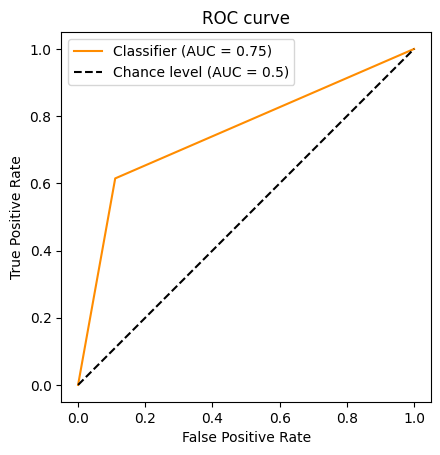

In [28]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#roc-curve-showing-a-specific-class
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_true,
    y_score,
    # name=f"{class_value} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

# Releasing resources

In [29]:
conn.close()
engine.dispose()

# References

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=BPYNAT_refapi#BPYNAT_refapi_irispackage_createconn

https://community.intersystems.com/post/sqlalchemy-easiest-way-use-python-and-sql-iriss-databases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html

https://docs.intersystems.com/irislatest/csp/docbook/DocBook.UI.Page.cls?KEY=GIML

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-all-ovr-roc-curves-together

https://learning.intersystems.com/course/view.php?id=1535&ssoPass=1